# Fill Discharge Data

The goal of this notebook is to extend the `nwis.get_dv()` for discharge data to search for nearby sites and use their discharge data to fill any missing data in the original site.

The general steps for this approach are:

1) Given a site, as well as neighborhood search parameters, search for sites on the stream's main stem for "neighboring" sites
    - The neighborhood search will assume the drainage area to the site is a circle and the radius of that circle is the distance to search within. This radius can then be scaled by some scale factor.
    - "Neighboring" sites can be both upstream or downstream.
2) Apply a filter to the "neighboring" sites, limiting to sites with discharge. Also, drop any sites on the main stem that somehow have drastically lower drainage areas.
3) Pull discharge data for each of the filtered "neighboring" sites.
4) Limit this discharge data to the dates with missing data in the original site.
5) Scale the discharge data associated with each "neighboring" site by the inverse of the fraction of its drainage area to the drainage area of the original site.
6) Fill the missing data in the original site preferentially using the "neighboring" site with data at that time and an inverse drainage area fraction closest to 1 (i.e., use the site with the drainage area most similar to the original site).

> Note: This method could be expanded to take tributaries as well (vs. just main stem) and add their discharge with the upstream main stem "neighboring" sites for more accurate discharge compared to just drainage area scaling.

In [1]:
from dataretrieval import nwis, nldi
import pandas as pd
import numpy as np
import xarray as xr
from sciencebasepy import SbSession
import os

/home/kdoore/software/miniforge3/envs/nutrients_iwaas/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


These are the inputs required for the method.

1) site number
2) start date of the discharge time series
3) end data of the discharge time series
4) factor to scale the drainage area radius for neighbor searching

In [2]:
site_no = '05586100'
start_date = '1900-01-01'
end_date = '2024-08-01'
neighborhood_scale = 0.2

Get the data for the original site.

In [3]:
# Get the discharge data for the site
df, _ = nwis.get_dv(sites=site_no, start=start_date, end=end_date, parameterCd='00060')
# Replace missing data (-999999) with NaN
df['00060_Mean'] = df['00060_Mean'].replace(-999999, np.nan)

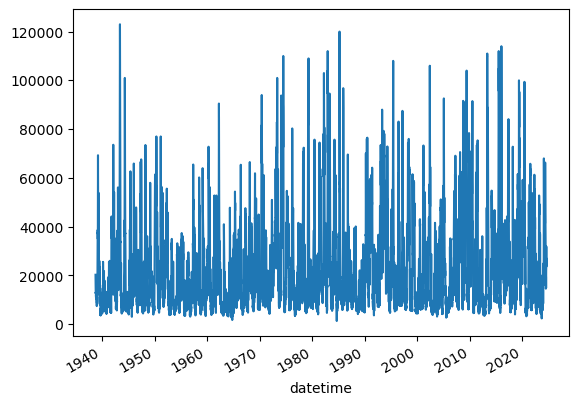

In [4]:
# Plot for fun
_ = df['00060_Mean'].plot()

Get the site drainage area info.

In [5]:
# Get you initial distance from the drainage area
df_nwis, _ = nwis.get_info(sites=site_no)

# To get a search radius for checking for neighboring sites,
# use the drainage area, assuming it is a circular area and
# use its radius as the search distance
# Note: the NWIS drainage area is in mi2
drainage_area = df_nwis['drain_area_va'][0]

# Check if the drainage area is missing. If it is,
# use the NLDI to get the area from the drainage basin.
# While this could be done regardless and is more accurate,
# perfect accuracy is not needed and it is not as fast.
# Note: the EPSG:5070 projection of the NLDI basin is in m.
m_per_mi = 1609.344
if np.isnan(drainage_area):
    basin = nldi.get_basin(feature_source="WQP",
                           feature_id=f"USGS-{site_no}")
    # Update crs
    basin = basin.set_crs('EPSG:4326').to_crs('EPSG:5070')
    # Get area. Convert to mi2
    drainage_area = basin.area[0] / (m_per_mi ** 2)

# Calculate neighbor search distance assuming circular drainage area
neighbor_distance = np.sqrt(drainage_area / np.pi) * neighborhood_scale
print(f'Drainage area [mi2]: {drainage_area}')
print(f'Neighbor search distance [mi]: {neighbor_distance}')

Drainage area [mi2]: 26743
Neighbor search distance [mi]: 18.452708512533455


Get the neighboring sites from the NLDI.

In [6]:
# Use NLDI to search upstream and downsteam for sites
# Note: NLDI features distance is in km
nldi_distance = neighbor_distance * m_per_mi / 1e3

# Search upstream and downstream on the main stem
gdf_features_up = nldi.get_features(feature_source="WQP", 
                                    feature_id=f"USGS-{site_no}",
                                    navigation_mode="UM",
                                    distance=nldi_distance,
                                    data_source="nwissite")
gdf_features_down = nldi.get_features(feature_source="WQP",
                                      feature_id=f"USGS-{site_no}",
                                      navigation_mode="DM",
                                      distance=nldi_distance,
                                      data_source="nwissite")
neighbor_sites = pd.concat([gdf_features_up['identifier'],
                            gdf_features_down['identifier']],
                           ignore_index=True)

# Drop the original site itself as it will be returned
neighbor_sites = neighbor_sites[neighbor_sites != f"USGS-{site_no}"]
neighbor_sites = neighbor_sites.str.strip('USGS-')
neighbor_sites

0    05585300
1    05585500
2    05586300
Name: identifier, dtype: object

Limit selected sites to only those with discharge measurements and those that have greater than 10% of the original site's drainage area.

In [7]:
# Get the info on the sites that have discharge measurements
df_neighbors, _ = nwis.get_info(sites=neighbor_sites.to_list(), parameterCd='00060')
# Keep those that are greater than 10% of the original drainage area
df_neighbors = df_neighbors[(df_neighbors['drain_area_va'] / drainage_area) > 0.1]
df_neighbors

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,05585500,"ILLINOIS RIVER AT MEREDOSIA, IL",ST,394952.2,903335.4,39.831167,-90.559833,X,F,...,N,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pull discharge data for each of the filtered "neighboring" sites.

We could also pull each site individually. By pulling individually, we would only pull the neighboring sites and fill missing data as needed, until our time range has been fully filled. This could save some data pulling if we have a lot of sites and only some missing data. However, it is not possible to know what sites have data on what days. Therefore, we can just pull it all and once and filter from there. This limits the number of NWIS API calls and should be faster.

In [14]:
# Get the discharge for the neighboring sites
neighbor_discharge, _ = nwis.get_dv(sites=df_neighbors['site_no'].to_list(), start=start_date, end=end_date, parameterCd='00060')
# Add multi-index to allow for easy xarray conversion
if 'site_no' in neighbor_discharge.columns:
    neighbor_discharge = neighbor_discharge.set_index(['site_no', neighbor_discharge.index])
neighbor_discharge = neighbor_discharge.to_xarray()
neighbor_discharge['datetime'] = pd.DatetimeIndex(neighbor_discharge['datetime'].values)

# Get the dates with missing values
missing = df[df['00060_Mean'].isna()].index.values
# Limit the missing dates to only be within the date range of the fill values
missing = missing[(missing >= neighbor_discharge['datetime'].min().values) 
                  & (missing <= neighbor_discharge['datetime'].max().values)]

# Limit this discharge data to the dates with missing data in the original site.
neighbor_discharge = neighbor_discharge.sel(datetime=missing)
neighbor_discharge

<xarray.Dataset> Size: 9kB
Dimensions:        (site_no: 1, datetime: 367)
Coordinates:
  * site_no        (site_no) object 8B '05585500'
  * datetime       (datetime) datetime64[ns] 3kB 1980-01-01 ... 1981-01-01
Data variables:
    00060_Mean     (site_no, datetime) float64 3kB 2.35e+04 ... 1.44e+04
    00060_Mean_cd  (site_no, datetime) object 3kB 'A' 'A' 'A' ... 'A' 'A' 'A'

Scale the discharge data associated with each "neighboring" site by the inverse of the fraction of its drainage area to the drainage area of the original site.

In [15]:
# Create the drainage fractions
neighbor_discharge['drainage_frac'] = xr.DataArray(drainage_area / df_neighbors.set_index('site_no')['drain_area_va'])
# Scale the discharge
neighbor_discharge['00060_Mean'] *= neighbor_discharge['drainage_frac']
neighbor_discharge

<xarray.Dataset> Size: 9kB
Dimensions:        (site_no: 1, datetime: 367)
Coordinates:
  * site_no        (site_no) object 8B '05585500'
  * datetime       (datetime) datetime64[ns] 3kB 1980-01-01 ... 1981-01-01
Data variables:
    00060_Mean     (site_no, datetime) float64 3kB 2.414e+04 ... 1.48e+04
    00060_Mean_cd  (site_no, datetime) object 3kB 'A' 'A' 'A' ... 'A' 'A' 'A'
    drainage_frac  (site_no) float64 8B 1.027

Fill the missing data in the original site preferentially using the "neighboring" site with data at that time and an inverse drainage area fraction closest to 1 (i.e., use the site with the drainage area most similar to the original site).

In [16]:
neighbor_discharge['frac_diff'] = np.abs(neighbor_discharge['drainage_frac'] - 1)
neighbor_discharge = neighbor_discharge.sortby('frac_diff')

for neighbor_site_no in neighbor_discharge['site_no'].values:
    fill_data = neighbor_discharge.sel(site_no=neighbor_site_no)['00060_Mean'].to_dataframe().drop(columns='site_no')
    fill_data.index = fill_data.index.tz_localize('utc')
    df = df.fillna(fill_data)

    # End early if we fill all missing data
    if df['00060_Mean'].isna().sum() == 0:
        break